# Running through results from the theory to determine the relevant parameter regimes

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

from ipywidgets import widgets
from IPython.display import display

import numpy as np
import pandas as pd
import seaborn as sns

 This theory is well characterized in microeconomics. First, for the record, the risk sensitivity generally does depend on the level of wealth. The _Arrow-Pratt coefficient of risk aversion_ is defined as
$$
 A(x) = - \frac{u''(x)}{u'(x)}
$$

which can evidently vary with wealth. I may return to this coefficient later.

Using an expected utility form, the portfolio allocation problem is:
$$
    \max_{0 \le r \le 1} \int u \big( (1-r)w + rwz \big) p(z) dz
$$

where $w$ is wealth, $r$ is the fraction allocated to the risky asset, and $z$ is the fold-change in the risky asset value.

Sampling $z$, we can find approximate solutions by optimizing. This has fairly large variance in the solutions that we find, but it's good enough for the purposes of characterization.


### The objective here is to find a parameter regime in which the optimal solutions vary over a reasonable range

There are two sources of variance in the solutions: changes in wealth, and changes in the amount of time remaining. Do the changes in remaining time matter? 

In [4]:
from groundTruth import findBestAction, findBestAction_determ

In [8]:
findBestAction(0.008, 0.2, 1., np.log)

     fun: -85.93459877923233
     jac: array([-8.39233398e-05])
 message: 'Optimization terminated successfully'
    nfev: 10
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.20587542])

In [12]:
base = []
scaled2 = []
scaled3 = []

for samples in range(1000):
    base.append(findBestAction(0.008, 0.2, 1., np.log).x[0] )
    scaled2.append( findBestAction(0.008*4, 0.2*2, 1., np.log).x[0] )
    scaled3.append( findBestAction(0.008*9, 0.2*3, 1., np.log).x[0] )
    
    if samples % 100==0:
        print(samples)

base = np.array(base)
scaled2 = np.array(scaled2)
scaled3 = np.array(scaled3)

0
100
200
300
400
500
600
700
800
900


In [25]:
print('Base: {mean} +- {sem}'.format(**{'mean': base.mean(), 'sem': base.std()/len(base) }))
print('scaled2: {mean} +- {sem}'.format(**{'mean': scaled2.mean(), 'sem': scaled2.std()/len(base) }))
print('scaled3: {mean} +- {sem}'.format(**{'mean': scaled3.mean(), 'sem': scaled3.std()/len(base) }))

Base: 0.19826708630417744 +- 1.575516072896693e-05
scaled2: 0.1929299527499124 +- 8.20804573133972e-06
scaled3: 0.18472148970403215 +- 5.671510167585498e-06


In [31]:
from scipy.stats import ttest_ind

print( ttest_ind(base, scaled2, equal_var=False) )
print( ttest_ind(base, scaled3, equal_var=False) )
print( ttest_ind(scaled3, scaled2, equal_var=False) )

Ttest_indResult(statistic=9.495641498441845, pvalue=8.26370538188007e-21)
Ttest_indResult(statistic=25.56811767236117, pvalue=2.184732434660149e-116)
Ttest_indResult(statistic=-26.00459198425001, pvalue=1.3535331868868796e-126)


Ok, so for the log objective function, there is a small but significant difference in the optimal actions at different times

In [34]:
base = []
scaled2 = []
scaled3 = []

for samples in range(1000):
    base.append(findBestAction(0.008, 0.2, 1., np.sqrt).x[0] )
    scaled2.append( findBestAction(0.008*4, 0.2*2, 1., np.sqrt).x[0] )
    scaled3.append( findBestAction(0.008*9, 0.2*3, 1., np.sqrt).x[0] )
    
    if samples % 100==0:
        print(samples)

base = np.array(base)
scaled2 = np.array(scaled2)
scaled3 = np.array(scaled3)

0
100
200
300
400
500
600
700
800
900


In [35]:
print('Base: {mean} +- {sem}'.format(**{'mean': base.mean(), 'sem': base.std()/len(base) }))
print('scaled2: {mean} +- {sem}'.format(**{'mean': scaled2.mean(), 'sem': scaled2.std()/len(base) }))
print('scaled3: {mean} +- {sem}'.format(**{'mean': scaled3.mean(), 'sem': scaled3.std()/len(base) }))

Base: 0.3986722317853587 +- 3.116367295307047e-05
scaled2: 0.3961747878303624 +- 1.6505537173108128e-05
scaled3: 0.39208367905965097 +- 1.1729334049028684e-05


In [36]:
from scipy.stats import ttest_ind

print( ttest_ind(base, scaled2, equal_var=False) )
print( ttest_ind(base, scaled3, equal_var=False) )
print( ttest_ind(scaled3, scaled2, equal_var=False) )

Ttest_indResult(statistic=2.2383957324377013, pvalue=0.025339679788478453)
Ttest_indResult(statistic=6.253967256016925, pvalue=5.447918867609082e-10)
Ttest_indResult(statistic=-6.385964905235018, pvalue=2.1614047502163774e-10)


The difference here for square root is similarly small, and not always very significant.

### There appear to be differences, albeit small, between optimal actions at different times.

In [15]:
def optimalAction(time, wealth, mu=0.006, sigma=0.2, utilityFn=np.sqrt):
    return findBestAction(mu*time, sigma*time**0.5, wealth, utilityFn).x[0]


def makeGrid(Times, Wealths, **kwargs):
    outputs = []
    for time, wealth in zip(Times.reshape(-1), Wealths.reshape(-1)):
        outputs.append( optimalAction(time, wealth, **kwargs) )
    outputs = np.array( outputs)
    return outputs.reshape(Times.shape)


(0.0, 1.0)

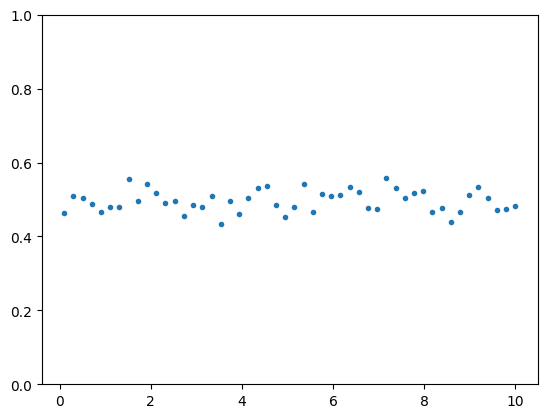

In [16]:
wealths = np.linspace(0.1, 10)
actions = []
for wealth in wealths:
    actions.append( optimalAction(1., wealth, mu=0.002, sigma=0.09, utilityFn=np.sqrt) );
    
plt.plot(wealths, actions, '.')
plt.ylim([0,1])

### Observations:

1. Large standard deviation in the geometric Brownian mostion seems to be key to achieving a reasonably smooth action curves. However, these also result in worse performance from sampling due to the large variances.

2. Taking more samples results in a lot of 50% solutions to the optimization problem (above). Why would this be?

3. Why does the optimal allocation _decrease_ with wealth? This is surprising.

### note: the above plots have since been re-run using a bug-fixed version. See Below

## 07/30 some answers:

1. There was a bug in the ground truth solution, which I fixed, removing much of the wealth effect. This also explains the decreasing wealth effect: I wasn't paying out properly in proportion to the amount wagered. Unfortunately, I reran the above plots, so the previous effect aren't visible any more.

2. I was using 50% as an initial guess, so this is probabily why many runs seem to default to that.

3. Using a numerical quadrature method is a reasonable way to go to avoid sampling issues, but it does make the optimization much slower.


Moving forward, there are two things to do.
1. Do the RL agents find the ground truths when they are approximately constant?
2. Is there a parameter region where the ground truths actually change a fair amount

In [1]:
%run groundTruth.py

def optimalAction(time, wealth, mu=0.006, sigma=0.2, utilityFn=np.sqrt):
    return findBestAction_determ(mu*time, sigma*time**0.5, wealth, utilityFn).x[0]


def makeGrid(Times, Wealths, **kwargs):
    outputs = []
    for time, wealth in zip(Times.reshape(-1), Wealths.reshape(-1)):
        outputs.append( optimalAction(time, wealth, **kwargs) )
    outputs = np.array( outputs)
    return outputs.reshape(Times.shape)

## Searching for wealth effects

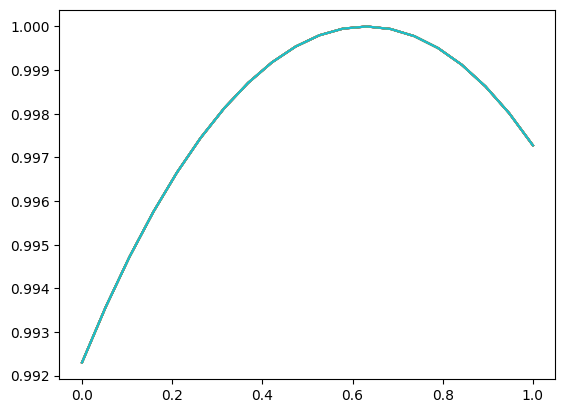

In [46]:
# plotting utility curves to avoid the slow optimization step
weights = np.linspace(0,1, 20)
wealths = np.logspace(-1, 2, 10)

for wealth in wealths:
    utilityCurve = utilityCurve_determ(0.05, 0.4, wealth, lambda x: np.sqrt(x))(weights)
    
    plt.plot( weights, utilityCurve /np.max(utilityCurve) , label=f'{wealth}' )

#plt.ylim([0,2])
#plt.legend()